# [20250327] BrainMRI image segmentation

In [43]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from glob import glob

import tensorflow as tf
import tensorflow_io as tfio

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# Print files

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [44]:
file_pattern = "/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/*/*[0-9].tif"

files = glob(file_pattern)
image_count = len(list(files))

print(f'detect {image_count} images')

detect 3929 images


In [45]:
list_ds = tf.data.Dataset.list_files(
    file_pattern,
    shuffle=False
)

list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

for f in list_ds.take(3):
  print(type(f))
  print(f.numpy())

<class 'tensorflow.python.framework.ops.EagerTensor'>
b'/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_8.tif'
<class 'tensorflow.python.framework.ops.EagerTensor'>
b'/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_18.tif'
<class 'tensorflow.python.framework.ops.EagerTensor'>
b'/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_32.tif'


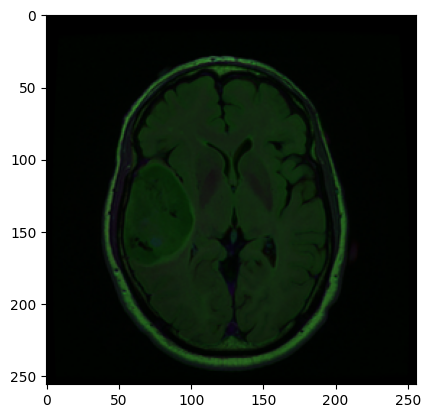

In [80]:
train_img = tf.io.read_file('/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_20_mask.tif')
train_tensor = tfio.experimental.image.decode_tiff(train_img)
plt.imshow(train_tensor)

In [47]:
def get_mask_path(file_path):
    path_list = tf.strings.split(file_path, '.')
    mask_path = tf.strings.join([path_list[0], '_mask.tif'])
    return mask_path

def get_rgb_tensor(file_path):
    file = tf.io.read_file(file_path)
    # print(type(file))
    file_tensor = tfio.experimental.image.decode_tiff(file)
    file_tensor = tf.ensure_shape(file_tensor, [None, None, 4])
    return tfio.experimental.color.rgba_to_rgb(file_tensor) 

In [48]:
def process_path(train_path):
    print(tf.executing_eagerly())
    train_tensor = get_rgb_tensor(train_path)
    train_tensor= tf.ensure_shape(train_tensor, [256, 256, 3])
    
    mask_path = get_mask_path(train_path)
    mask_tensor = get_rgb_tensor(mask_path)
    mask_tensor = tf.image.rgb_to_grayscale(mask_tensor)
    mask_tensor = tf.keras.ops.divide(mask_tensor, 255.0)
    mask_tensor= tf.ensure_shape(mask_tensor, [256, 256, 1])
    return train_tensor, mask_tensor
    # return tf.image.resize(train_tensor, [256, 256]), tf.image.resize(mask_tensor, [256, 256])

In [49]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [50]:
print(f'train size:      {tf.data.experimental.cardinality(train_ds).numpy()}')
print(f'validation size: {tf.data.experimental.cardinality(val_ds).numpy()}')

train size:      3144
validation size: 785


In [51]:
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

False
False


In [52]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(32)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

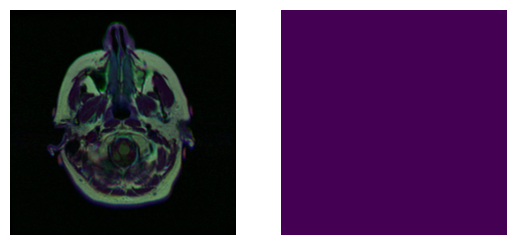

In [148]:
for img, mask in train_ds.take(1):
    plt.subplot(1, 2, 1)
    plt.imshow(img[0])
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask[0])
    plt.axis('off')

In [54]:
def convnet():
    input_layer = tf.keras.Input(shape=(256,256,3))
    
    x = tf.keras.layers.Conv2D(64, (3, 3))(input_layer) # 254x254x64
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(64, (3, 3))(x) # 252x254x64
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D()(x) # 126x126x64

    x = tf.keras.layers.Conv2D(128, (3, 3))(x) # 124x124x128
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D()(x) # 62x62x128

    x = tf.keras.layers.Conv2D(256, (3, 3))(x) # 60x60x256
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(256, (3, 3))(x) # 58x58x256
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2DTranspose(256, (3, 3))(x) # 60x60x256
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2DTranspose(128, (3, 3))(x) # 62x62x128
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2))(x) # 124x124x256
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2DTranspose(64, (3, 3))(x) # 126x126x64
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2))(x) # 252x252x64
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2DTranspose(64, (3, 3))(x) # 254x254x64
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2DTranspose(1, (3, 3))(x) # 256x256x1
    output_layer = tf.keras.layers.Activation('sigmoid')(x)
    return tf.keras.Model(inputs=input_layer, outputs=output_layer)

In [55]:
model = convnet()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 254, 254, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 254, 254, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 252, 252, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 252, 252, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 126, 126, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 124, 124, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 124, 124, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 62, 62, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 60, 60, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 58, 58, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 58, 58, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 60, 60, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_8 (Conv2DTranspose) │ (None, 62, 62, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 62, 62, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_9 (Conv2DTranspose) │ (None, 124, 124, 128)       │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_19 (Activation)           │ (None, 124, 124, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_10                  │ (None, 126, 126, 64)        │          73,792 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_20 (Activation)           │ (None, 126, 126, 64)        │              

 Total params: 2,076,353 (7.92 MB)

 Trainable params: 2,076,353 (7.92 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [96]:
model.fit(train_ds, epochs=10)

Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 27s 271ms/step - accuracy: 0.9898 - loss: 0.0319
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 27s 271ms/step - accuracy: 0.9898 - loss: 0.0288
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 27s 271ms/step - accuracy: 0.9898 - loss: 0.0294
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 27s 271ms/step - accuracy: 0.9898 - loss: 0.0265
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 27s 271ms/step - accuracy: 0.9901 - loss: 0.0232
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 27s 271ms/step - accuracy: 0.9898 - loss: 0.0254
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 27s 271ms/step - accuracy: 0.9933 - loss: 0.0209
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 27s 271ms/step - accuracy: 0.9936 - loss: 0.0199
Epoch 9/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 27s 271ms/step - accuracy: 0.9941 - loss: 0.0186
Epoch 10/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 27s 271ms/step - accuracy: 0.9942 - loss: 0.0183


In [59]:
np.max(model.predict(val_ds)[30])

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step


0.42603773

In [142]:
train_img = tf.io.read_file('/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_25.tif')
train_tensor = tfio.experimental.image.decode_tiff(train_img)
train_tensor = tfio.experimental.color.rgba_to_rgb(train_tensor) 

mask_img = tf.io.read_file('/kaggle/input/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_25_mask.tif')
mask_tensor = tfio.experimental.image.decode_tiff(mask_img)
mask_tensor = tfio.experimental.color.rgba_to_rgb(mask_tensor) 
mask_tensor = tf.image.rgb_to_grayscale(mask_tensor)
mask_tensor = tf.keras.ops.divide(mask_tensor, 255.0)

In [143]:
train_tensor = train_tensor[tf.newaxis, ...]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


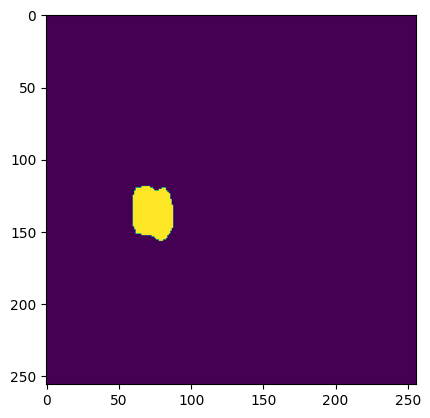

In [144]:
plt.imshow(model.predict(train_tensor)[0] > 0.5)

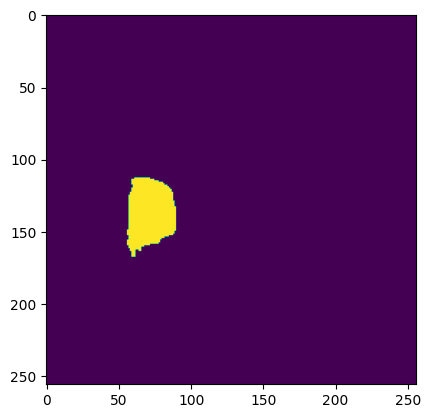

In [145]:
plt.imshow(mask_tensor)

In [146]:
model.evaluate(val_ds)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.9947 - loss: 0.0156


[0.015449277125298977, 0.9946555495262146]